In [85]:
import cv2
import gym_duckietown
import matplotlib.pyplot as plt
import numpy as np

from gym_duckietown.simulator import Simulator

#gym_duckietown is very chatty
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

import utils

In [86]:
plt.rcParams['figure.figsize'] = [7, 7]

/home/giulio/prog/duckrace/utils.py:390: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  points_fitted = np.vstack( spl(alpha) for spl in splines ).T


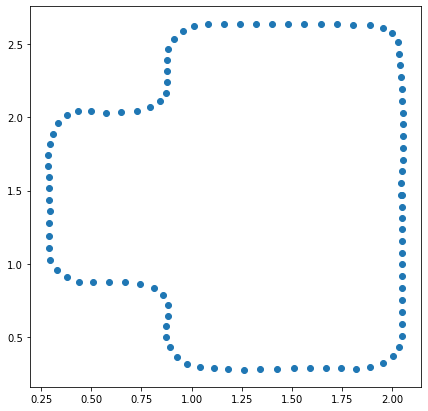

In [87]:
env = Simulator("ETH_large_loop",
    full_transparency=True,
    domain_rand=False,
    user_tile_start=[3,1],
    seed=42,
    max_steps=float("inf"),
)

env.unwrapped.start_pose = [[0.11699990272521976, 0, 0.41029359288296474], -np.pi/2]
env.reset()

traj = utils.get_trajectory(env, samples=100, method="distance", last_value_distance=1.035)
plt.scatter(*traj.T)

In [88]:
(env.grid_height*env.road_tile_size, env.grid_width*env.road_tile_size)

(2.925, 2.34)

In [89]:
traj[:,0].max() - traj[:,0].min()

1.7712502203803036

In [90]:
traj[:,1].max() - traj[:,1].min()

2.3601942364871467

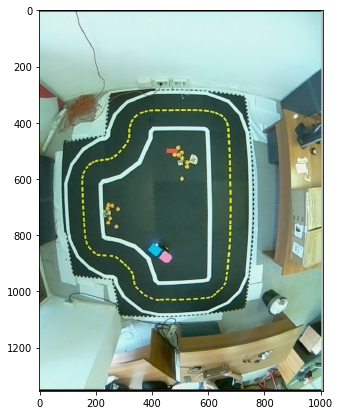

In [91]:
import copy

img = cv2.imread("assets/topview_verde.png")
img = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#scale_x, scale_y, offset_x, offset_y = utils.calibration_params(traj, img)

plt.imshow(img_rgb)
#plt.plot(*utils.use_calibration(copy.deepcopy(traj), scale_x=scale_x, scale_y=scale_y, offset_x=offset_x, offset_y=offset_y).T)

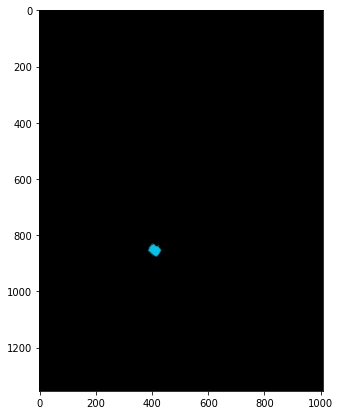

In [92]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hsv_color1_blue = np.array([50, 200, 90])
hsv_color2_blue = np.array([100, 300, 300])

mask_blue = cv2.inRange(img_hsv, hsv_color1_blue, hsv_color2_blue)

plt.imshow(cv2.bitwise_and(img_rgb,img_rgb,mask=mask_blue), cmap='gray')
#plt.plot(*np.argwhere(mask_blue==255).T, "*")
mask = mask_blue

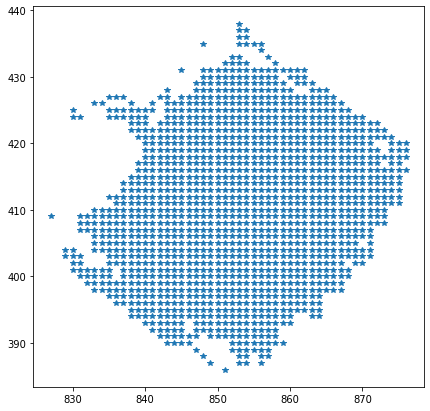

In [93]:
plt.plot(*np.argwhere(mask_blue==255).T, "*")

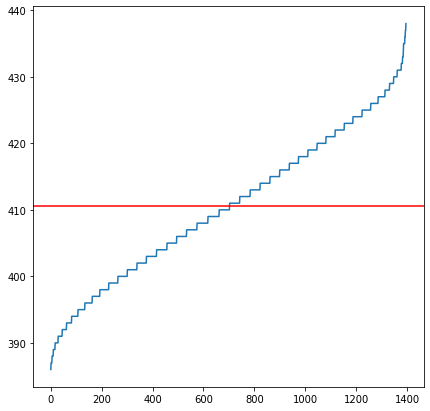

In [94]:
plt.plot(np.sort(np.argwhere(mask_blue==255)[:,1]))
plt.axhline(y=np.argwhere(mask_blue==255).mean(axis=0)[1], color='r', linestyle='-')

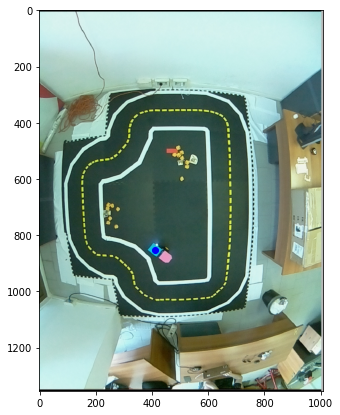

In [96]:
plt.imshow(img_rgb)
plt.scatter(*np.argwhere(mask_blue==255).mean(axis=0)[::-1], color="blue")

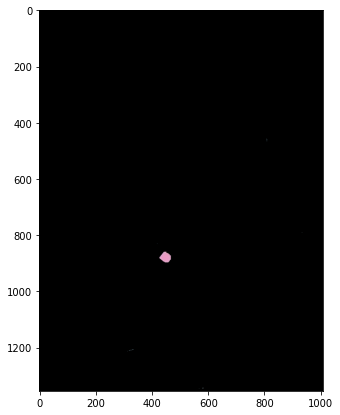

In [103]:
img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

hsv_color1_pink = np.array([100, 50, 200])
hsv_color2_pink = np.array([200, 200, 250])

mask_pink = cv2.inRange(img_hsv, hsv_color1_pink, hsv_color2_pink)

plt.imshow(cv2.bitwise_and(img_rgb,img_rgb,mask=mask_pink), cmap='gray')

mask = mask_pink

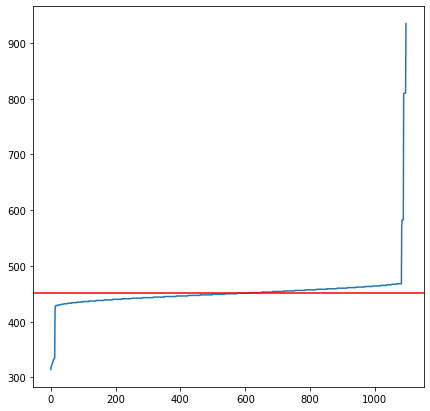

In [104]:
plt.plot(np.sort(np.argwhere(mask_pink==255)[:,1]))
plt.axhline(y=np.argwhere(mask_pink==255).mean(axis=0)[1], color='r', linestyle='-')

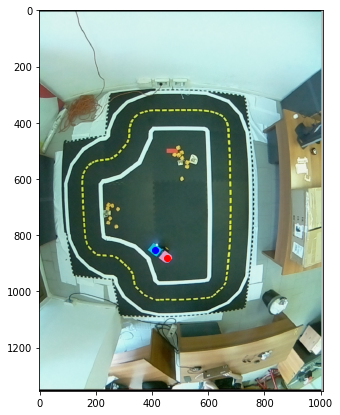

In [98]:
plt.imshow(img_rgb)
front_coo = np.argwhere(mask_pink==255).mean(axis=0)[::-1]
back_coo = np.argwhere(mask_blue==255).mean(axis=0)[::-1]
plt.scatter(*front_coo, color="red")
plt.scatter(*back_coo, color="blue")

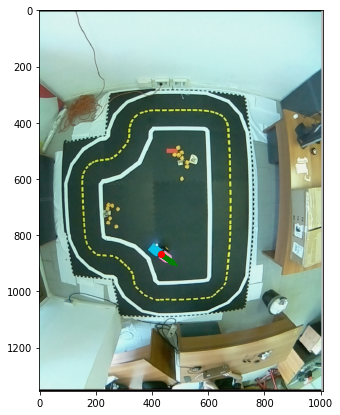

In [99]:
plt.imshow(img_rgb)
x_center = (front_coo[0] + back_coo[0])/2
y_center = (front_coo[1] + back_coo[1])/2
angle = np.arctan2(-front_coo[1]+back_coo[1], -front_coo[0]+back_coo[0])
plt.arrow(x_center, y_center, -50*np.cos(angle), -50*np.sin(angle), shape='full', lw=5, length_includes_head=True, head_width=.05, color="green")
plt.scatter(x_center, y_center, color="red")

In [100]:
np.rad2deg(angle)

-144.78208115514192

In [101]:
def get_cars(img):
    """
    Returns front and left coord
    """
    img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

    hsv_color1_blue = np.array([50, 200, 50])
    hsv_color2_blue = np.array([100, 300, 300])
    mask_blue = cv2.inRange(img_hsv, hsv_color1_blue, hsv_color2_blue)

    hsv_color1_pink = np.array([100, 50, 200])
    hsv_color2_pink = np.array([200, 200, 250])
    mask_pink = cv2.inRange(img_hsv, hsv_color1_pink, hsv_color2_pink)
    
    front_coo = np.argwhere(mask_pink==255).mean(axis=0)[::-1]
    back_coo = np.argwhere(mask_blue==255).mean(axis=0)[::-1]
    
    x_center = (front_coo[0] + back_coo[0])/2
    y_center = (front_coo[1] + back_coo[1])/2
    angle = np.arctan2(-front_coo[1]+back_coo[1], -front_coo[0]+back_coo[0])
    
    return x_center, y_center, angle

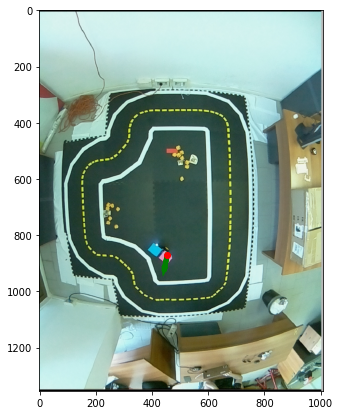

In [102]:
plt.imshow(img_rgb)
x, y, t = get_cars(img)
plt.arrow(x, y, -50*np.cos(t), -50*np.sin(t), shape='full', lw=5, length_includes_head=True, head_width=.05, color="green")
plt.scatter(x, y, color="red")